# Functions and Function Spaces

Functions and function-spaces motivate neural operators. While conventional neural networks learn between vector-spaces, neural operators learn maps between  infinite-dimensional function spaces.

This notebook gives an introduction into functions, function spaces (function sets), how they motivate neural operators and how these basic concepts are implemented in Continuity.

**Note**: This notebook currently gives an introduction into functions, but will be extended to all other concepts in the future.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
x_plot = torch.linspace(-1, 1, 300)

## Sets

In maths sets are is a collection of distinct objects. A set is denoted by curly brackets, for example
$$
S=\{ a, b, c\}
$$
is a set containing the elements $a, b$ and $c$.

## Vector Spaces
A vector space is a set of vectors. Elements from this set may be added together or multiplied by scalars. A vector space over a field $F$ is denoted as
$$
V(F).
$$
The field $F$ is a set on which addition, subtraction, multiplication, and division are defined. In this context the elements of this vector space $V$ are called vectors and the elements of $F$ are called scalars.

## Functions

A function is a mapping between a set $X$ (domain) and a second set $Y$ (codomain). A function $f$ mapping from a set $A$ to a set $B$ is denoted as
$$
f: A \rightarrow B.
$$
For example the function $f(x)=x^2$ maps each element $x\in \mathcal A$ to an element of set $B$. In physics these vector spaces are usually a set of real or complex numbers. For $f$ the domain and codomain are identical. 

In Continuity the concepts of sets and vector spaces are not explicitly implemented and left for to the user. In Continuity functions are described by creating a `Function` object that takes a callable as input. As an example we are going to define two functions $f$ and $g$: 
$$f:x\mapsto \sin(\pi x),\qquad g:x\mapsto x^3, \qquad x\in \mathbb{R}.$$

In [4]:
from continuity.data.function import Function

f = Function(lambda x: torch.sin(torch.pi * x))
g = Function(lambda x: x ** 3)

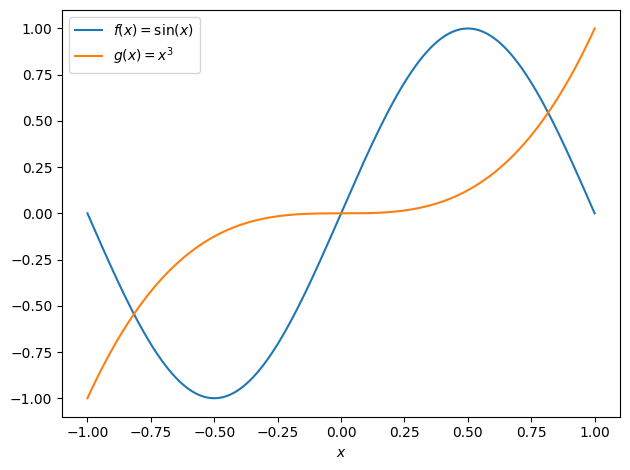

In [5]:
plt.plot(x_plot, f(x_plot), label="$f(x)=\sin(x)$")
plt.plot(x_plot, g(x_plot), label="$g(x)=x^3$")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()

Functions are evaluated by calling them. They can be added to, subtracted from, multiplied with, divided by other functions.

In [6]:
h_sum = f + g
h_sub = f - g
h_mul = f * g
h_div = f / g

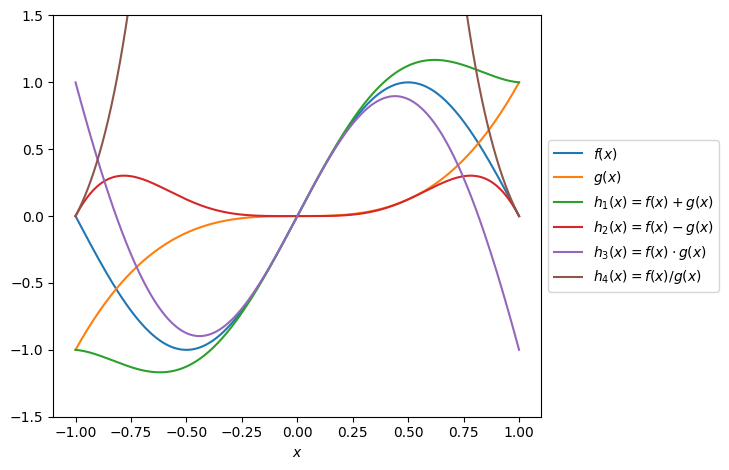

In [7]:
fig, ax = plt.subplots()
ax.plot(x_plot, f(x_plot), label="$f(x)$")
ax.plot(x_plot, g(x_plot), label="$g(x)$")
ax.plot(x_plot, h_sum(x_plot), label="$h_1(x)=f(x)+g(x)$")
ax.plot(x_plot, h_mul(x_plot), label="$h_2(x)=f(x)-g(x)$")
ax.plot(x_plot, h_sub(x_plot), label="$h_3(x)=f(x)\cdot g(x)$")
ax.plot(x_plot, h_div(x_plot), label="$h_4(x)=f(x) / g(x)$")
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("$x$")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()